In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import wordcloud
from wordcloud import WordCloud, STOPWORDS

#To create content-based filtering model
from sklearn.manifold import TSNE
import plotly.express as px
from ipywidgets import interact

#To create collaborative filtering model
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

# To create deep learning models
from keras.layers import Input, Embedding, Reshape, Dot, Concatenate, Dense, Dropout
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error 


import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
df = pd.read_csv('C:/Users/victo/Documents/Institute_of_Data/Capstone Project/movies.csv')
df

movieId                               title    year  \
0            1                    Toy Story (1995)  1995.0   
1            2                      Jumanji (1995)  1995.0   
2            3             Grumpier Old Men (1995)  1995.0   
3            4            Waiting to Exhale (1995)  1995.0   
4            5  Father of the Bride Part II (1995)  1995.0   
...        ...                                 ...     ...   
27273   131254        Kein Bund für's Leben (2007)  2007.0   
27274   131256       Feuer, Eis & Dosenbier (2002)  2002.0   
27275   131258                  The Pirates (2014)  2014.0   
27276   131260                 Rentun Ruusu (2001)  2001.0   
27277   131262                    Innocence (2014)  2014.0   

                                            genres  
0      Adventure|Animation|Children|Comedy|Fantasy  
1                       Adventure|Children|Fantasy  
2                                   Comedy|Romance  
3                             Comedy|Drama|Romance  
4                                           Comedy  
...                                            ...  
27273                                       Comedy  
27274                                       Comedy  
27275                                    Adventure  
27276                           (no genres listed)  
27277                     Adventure|Fantasy|Horror  

[27278 rows x 4 columns]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  27278 non-null  int64  
 1   title    27278 non-null  object 
 2   year     27260 non-null  float64
 3   genres   27278 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 852.6+ KB


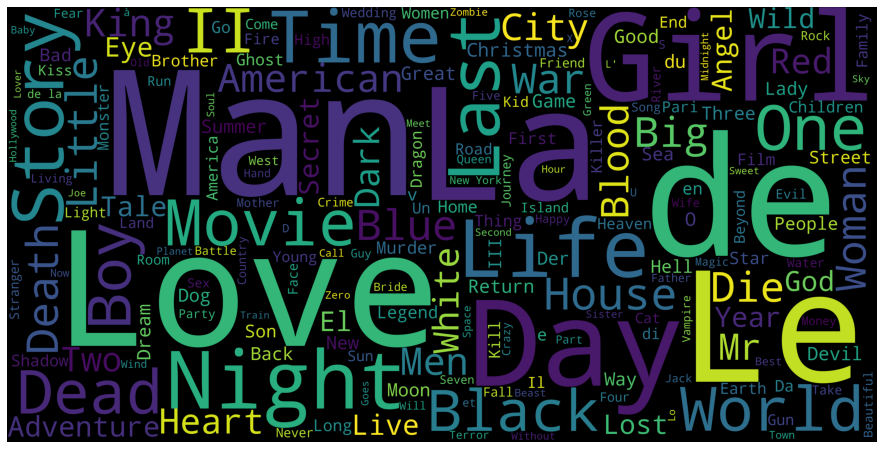

In [4]:
#Find most popular words in movie title 
df['title'] = df['title'].fillna("").astype('str')
title_corpus = ' '.join(df['title'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=4000).generate(title_corpus)

# Plot the wordcloud
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

In [5]:
# Make a census of the genre keywords
genre_labels = set()
for s in df['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))

# Function that counts the number of times each of the genre keywords appear
def count_word(dataset, ref_col, census):
    keyword_count = dict()
    for s in census: 
        keyword_count[s] = 0
    for census_keywords in dataset[ref_col].str.split('|'):        
        if type(census_keywords) == float and pd.isnull(census_keywords): 
            continue        
        for s in [s for s in census_keywords if s in census]: 
            if pd.notnull(s): 
                keyword_count[s] += 1
    #______________________________________________________________________
    # convert the dictionary in a list to sort the keywords by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

# Calling this function gives access to a list of genre keywords which are sorted by decreasing frequency
keyword_occurences, dum = count_word(df, 'genres', genre_labels)
keyword_occurences[:20]

[['Drama', 13344],
 ['Comedy', 8374],
 ['Thriller', 4178],
 ['Romance', 4127],
 ['Action', 3520],
 ['Crime', 2939],
 ['Horror', 2611],
 ['Documentary', 2471],
 ['Adventure', 2329],
 ['Sci-Fi', 1743],
 ['Mystery', 1514],
 ['Fantasy', 1412],
 ['War', 1194],
 ['Children', 1139],
 ['Musical', 1036],
 ['Animation', 1027],
 ['Western', 676],
 ['Film-Noir', 330],
 ['(no genres listed)', 246],
 ['IMAX', 196]]

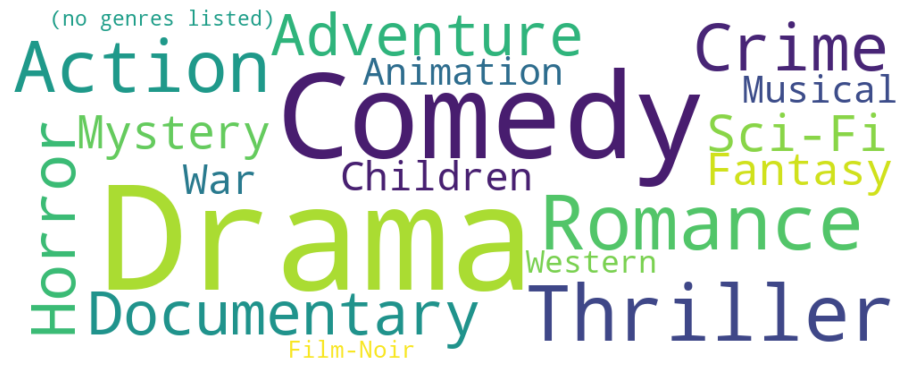

In [6]:

# Define the dictionary used to produce the genre wordcloud
genres = dict()
trunc_occurences = keyword_occurences[0:19]
for s in trunc_occurences:
    genres[s[0]] = s[1]

# Create the wordcloud
genre_wordcloud = WordCloud(width=1000,height=400, background_color='white')
genre_wordcloud.generate_from_frequencies(genres)

# Plot the wordcloud
f, ax = plt.subplots(figsize=(16, 8))
plt.imshow(genre_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

# MODEL 1 - Content-Based Filtering

In [4]:
#select first 5000 movies only due to low computational power

df1 = df.loc[:4999]
df1

movieId                               title    year  \
0           1                    Toy Story (1995)  1995.0   
1           2                      Jumanji (1995)  1995.0   
2           3             Grumpier Old Men (1995)  1995.0   
3           4            Waiting to Exhale (1995)  1995.0   
4           5  Father of the Bride Part II (1995)  1995.0   
...       ...                                 ...     ...   
4995     5091        The Man from Acapulco (1973)  1973.0   
4996     5092                 Big Fat Liar (2002)  2002.0   
4997     5093            Collateral Damage (2002)  2002.0   
4998     5094                   Rollerball (2002)  2002.0   
4999     5095                Scotland, Pa. (2001)  2001.0   

                                           genres  
0     Adventure|Animation|Children|Comedy|Fantasy  
1                      Adventure|Children|Fantasy  
2                                  Comedy|Romance  
3                            Comedy|Drama|Romance  
4                                          Comedy  
...                                           ...  
4995                Action|Comedy|Fantasy|Romance  
4996                              Children|Comedy  
4997                              Action|Thriller  
4998                                Action|Sci-Fi  
4999                                 Comedy|Crime  

[5000 rows x 4 columns]

In [5]:
# Initialize dictionary, list, and initial index

genres_idx = {}
corpus = []
idx = 0

for i in range(len(df1)):
    genres = df1['genres'][i]
    
    tokens = genres.split('|')
    corpus.append(tokens)
    for genre in tokens:
        if genre not in genres_idx:
                genres_idx[genre] = idx
                idx += 1

In [6]:
# Get the number of items and tokens
M = len(df1)                 # The number of the items
N = len(genres_idx)     # The number of the ingredients

# Initialize a matrix of zeros
A = np.zeros(shape = (M, N))

In [7]:
# Define the encoder function
def encoder(tokens):
    x = np.zeros(N)
    for t in tokens:
        # Get the index for each ingredient
        idx = genres_idx[t]
        # Put 1 at the corresponding indices
        x[idx] = 1
    return x

In [8]:
# Make a document-term matrix
i = 0
for tokens in corpus:
    A[i, :] = encoder(tokens)
    i += 1

In [9]:
genres_idx

{'Adventure': 0,
 'Animation': 1,
 'Children': 2,
 'Comedy': 3,
 'Fantasy': 4,
 'Romance': 5,
 'Drama': 6,
 'Action': 7,
 'Crime': 8,
 'Thriller': 9,
 'Horror': 10,
 'Mystery': 11,
 'Sci-Fi': 12,
 'IMAX': 13,
 'Documentary': 14,
 'War': 15,
 'Musical': 16,
 'Western': 17,
 'Film-Noir': 18}

In [10]:
A

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [11]:
pd.DataFrame(A)

0    1    2    3    4    5    6    7    8    9    10   11   12   13  \
0     1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1     1.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2     0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3     0.0  0.0  0.0  1.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4     0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
4995  0.0  0.0  0.0  1.0  1.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
4996  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4997  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0   
4998  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0   
4999  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0   

       14   15   16   17   18  
0     0.0  0.0  0.0  0.0  0.0  
1     0.0  0.0  0.0  0.0  0.0  
2     0.0  0.0  0.0  0.0  0.0  
3     0.0  0.0  0.0  0.0  0.0  
4     0.0  0.0  0.0  0.0  0.0  
...   ...  ...  ...  ...  ...  
4995  0.0  0.0  0.0  0.0  0.0  
4996  0.0  0.0  0.0  0.0  0.0  
4997  0.0  0.0  0.0  0.0  0.0  
4998  0.0  0.0  0.0  0.0  0.0  
4999  0.0  0.0  0.0  0.0  0.0  

[5000 rows x 19 columns]

In [12]:
# Dimension reduction with t-SNE
model = TSNE(n_components = 2, learning_rate = 50, random_state=42)
tsne_features = model.fit_transform(A)

# Make X, Y columns
df1['T-SNE 1'] = tsne_features[:, 0]
df1['T-SNE 2'] = tsne_features[:, 1]

In [13]:
df1

movieId                               title    year  \
0           1                    Toy Story (1995)  1995.0   
1           2                      Jumanji (1995)  1995.0   
2           3             Grumpier Old Men (1995)  1995.0   
3           4            Waiting to Exhale (1995)  1995.0   
4           5  Father of the Bride Part II (1995)  1995.0   
...       ...                                 ...     ...   
4995     5091        The Man from Acapulco (1973)  1973.0   
4996     5092                 Big Fat Liar (2002)  2002.0   
4997     5093            Collateral Damage (2002)  2002.0   
4998     5094                   Rollerball (2002)  2002.0   
4999     5095                Scotland, Pa. (2001)  2001.0   

                                           genres    T-SNE 1    T-SNE 2  
0     Adventure|Animation|Children|Comedy|Fantasy  -0.410604  12.593392  
1                      Adventure|Children|Fantasy  -2.952520  14.960968  
2                                  Comedy|Romance -45.836681  16.916542  
3                            Comedy|Drama|Romance -47.075024 -34.413357  
4                                          Comedy   7.372942 -22.336802  
...                                           ...        ...        ...  
4995                Action|Comedy|Fantasy|Romance -37.680000  15.008536  
4996                              Children|Comedy   4.081730   5.485509  
4997                              Action|Thriller -27.345905   1.837736  
4998                                Action|Sci-Fi -17.278709   3.701543  
4999                                 Comedy|Crime -21.662313 -12.796081  

[5000 rows x 6 columns]

In [14]:
x = df1['T-SNE 1']
y = df1['T-SNE 2']

hover_data = {'genres':True}
              
fig = px.scatter(df1, x=x, y=y, hover_name='title', hover_data=hover_data, color='genres')

fig.show()

In [15]:
#create dropdown menu -'year'

option_1 = df1.year.unique().tolist()

def f(year):
    
    x = df1[df1['year'] == year]['T-SNE 1']
    y = df1[df1['year'] == year]['T-SNE 2']
    
    labels = {'x':'T-SNE 1', 'y': 'T-SNE 2'}
    
    hover_data = {'genres':True}
    
    fig = px.scatter(df1[df1['year'] == year], x=x, y=y, hover_name='title', hover_data=hover_data,
                     color='genres', labels=labels)
    
    fig.show()


In [16]:
interact(f, year = option_1)

interactive(children=(Dropdown(description='year', options=(1995.0, 1994.0, 1996.0, 1976.0, 1992.0, 1988.0, 19…

<function __main__.f(year)>

In [17]:
def movierecommendation_by_genre(movie_title):
    
    df1.reset_index().drop('index', axis=1)
    
    df1['distance'] = 0.0
    

    
    myItem = df1[df1['title'] == movie_title ]
    
    P1 = np.array([myItem['T-SNE 1'].values, myItem['T-SNE 2'].values])
    
    for i in range(len(df1)):
        P2 = np.array([df1['T-SNE 1'][i], df1['T-SNE 2'][i]]).reshape(-1,1)
        df1.distance[i] = np.sqrt( np.square(P1-P2).sum() )
    
    
    df_3 = df1.sort_values('distance').head(11).reset_index()
    
    df_4 = df_3 [['title', 'genres', 'distance']]
    
    return df_4

In [18]:
movierecommendation_by_genre('Toy Story (1995)')

title  \
0                                  Toy Story (1995)   
1                                Toy Story 2 (1999)   
2                                       Antz (1998)   
3                             Monsters, Inc. (2001)   
4                  Emperor's New Groove, The (2000)   
5    Adventures of Rocky and Bullwinkle, The (2000)   
6                   Who Framed Roger Rabbit? (1988)   
7                                  Space Jam (1996)   
8                                      Shrek (2001)   
9   Grand Day Out with Wallace and Gromit, A (1989)   
10             Kid in King Arthur's Court, A (1995)   

                                               genres  distance  
0         Adventure|Animation|Children|Comedy|Fantasy  0.000000  
1         Adventure|Animation|Children|Comedy|Fantasy  0.000826  
2         Adventure|Animation|Children|Comedy|Fantasy  0.000847  
3         Adventure|Animation|Children|Comedy|Fantasy  0.001009  
4         Adventure|Animation|Children|Comedy|Fantasy  0.001269  
5         Adventure|Animation|Children|Comedy|Fantasy  0.001325  
6   Adventure|Animation|Children|Comedy|Crime|Fant...  0.036941  
7   Adventure|Animation|Children|Comedy|Fantasy|Sc...  0.128018  
8   Adventure|Animation|Children|Comedy|Fantasy|Ro...  0.386602  
9          Adventure|Animation|Children|Comedy|Sci-Fi  1.121966  
10          Adventure|Children|Comedy|Fantasy|Romance  1.218575

In [19]:
movierecommendation_by_genre('Big Fat Liar (2002)')

title           genres  distance
0                             Big Fat Liar (2002)  Children|Comedy  0.000000
1                    Max Keeble's Big Move (2001)  Children|Comedy  0.026924
2                        Dunston Checks In (1996)  Children|Comedy  0.047385
3                             House Arrest (1996)  Children|Comedy  0.064136
4                            Love Bug, The (1969)  Children|Comedy  0.084869
5                             It Takes Two (1995)  Children|Comedy  0.109788
6                                First Kid (1996)  Children|Comedy  0.112425
7                   Angels in the Outfield (1994)  Children|Comedy  0.137230
8                     D3: The Mighty Ducks (1996)  Children|Comedy  0.157596
9                          Shaggy Dog, The (1959)  Children|Comedy  0.183761
10  Jungle2Jungle (a.k.a. Jungle 2 Jungle) (1997)  Children|Comedy  0.215058

# MODEL 2 - Collaborative-Based Filtering 

In [21]:
df_cf = pd.read_csv('C:/Users/victo/Documents/Institute_of_Data/Capstone Project/data_final.csv')
df_cf

User_ID  Movie_ID                                        Movie_Title  \
0              1         2                                     Jumanji (1995)   
1              1        29  City of Lost Children, The (CitÃ© des enfants ...   
2              1        32          Twelve Monkeys (a.k.a. 12 Monkeys) (1995)   
3              1        47                        Seven (a.k.a. Se7en) (1995)   
4              1        50                         Usual Suspects, The (1995)   
...          ...       ...                                                ...   
1048570     7120       168                                First Knight (1995)   
1048571     7120       253  Interview with the Vampire: The Vampire Chroni...   
1048572     7120       260          Star Wars: Episode IV - A New Hope (1977)   
1048573     7120       261                                Little Women (1994)   
1048574     7120       266                         Legends of the Fall (1994)   

         Rating                                  Genres        Timestamp  
0           3.5              Adventure|Children|Fantasy  2/04/2005 23:53  
1           3.5  Adventure|Drama|Fantasy|Mystery|Sci-Fi  2/04/2005 23:31  
2           3.5                 Mystery|Sci-Fi|Thriller  2/04/2005 23:33  
3           3.5                        Mystery|Thriller  2/04/2005 23:32  
4           3.5                  Crime|Mystery|Thriller  2/04/2005 23:29  
...         ...                                     ...              ...  
1048570     5.0                    Action|Drama|Romance  2/04/2007 19:44  
1048571     4.0                            Drama|Horror  2/04/2007 19:30  
1048572     5.0                 Action|Adventure|Sci-Fi  2/04/2007 19:27  
1048573     4.0                                   Drama  2/04/2007 19:49  
1048574     3.5               Drama|Romance|War|Western  2/04/2007 19:34  

[1048575 rows x 6 columns]

In [22]:
reader = Reader()
data = Dataset.load_from_df(df_cf[['User_ID', 'Movie_ID', 'Rating']], reader)

In [23]:
svd = SVD(verbose=True, n_epochs=10)
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8629  0.8620  0.8635  0.8628  0.0006  
MAE (testset)     0.6641  0.6641  0.6641  0.6641  0.0000  
Fit time          14.11   13.78   14.07   13.99   0.15    
Test time         2.38    2.45    2.46    2.43    0.03    


{'test_rmse': array([0.86289166, 0.86199367, 0.86346383]),
 'test_mae': array([0.66409712, 0.66411848, 0.66412148]),
 'fit_time': (14.109089374542236, 13.78312087059021, 14.070473909378052),
 'test_time': (2.381370782852173, 2.447267532348633, 2.460035800933838)}

In [24]:
trainset = data.build_full_trainset()
svd.fit(trainset)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9


In [25]:
#example - what is the rating prediction on movie_ID 80 for User_ID 5
svd.predict(uid=5, iid=80)

Prediction(uid=5, iid=80, r_ui=None, est=4.384618011005992, details={'was_impossible': False})

In [26]:
def collab_filter_recommendation(userID):
    
    #find number of movies that userID have already rated
    df_rated = df_cf[df_cf['User_ID'] == userID]
    print('User {0} has already rated {1} movies.'.format(userID, df_rated.shape[0]))
    
    #create new dataframe with movies that have not been rated by userID
    df_not_rated = df_cf[df_cf['User_ID'] != userID]
    
    
    # Estimated prediction using svd
    df_not_rated['Estimated Prediction'] = df_not_rated['Movie_ID'].apply(lambda x: svd.predict(userID, x).est)
    # Rank movies according to the predicted values
    df_not_rated = df_not_rated.sort_values('Estimated Prediction', ascending=False)
    
    #drop duplicated movies
    df_final = df_not_rated.drop_duplicates(subset=['Movie_Title'], keep='first')
    df_final = df_final.reset_index(drop=True)
    
    print('================================================')
    
    print('Top 10 recommended movies that User {0} will hopefully enjoy: '.format(userID))
    
    # Display top 10 recommended movies user may enjoy 
    return df_final[{'Movie_Title', 'Genres', 'Estimated Prediction'}].head(10)

In [27]:
collab_filter_recommendation(5)

User 5 has already rated 66 movies.
Top 10 recommended movies that User 5 will hopefully enjoy: 


Movie_Title  Estimated Prediction  \
0                   Shawshank Redemption, The (1994)              5.000000   
1  Raiders of the Lost Ark (Indiana Jones and the...              5.000000   
2                            Band of Brothers (2001)              5.000000   
3                                      Cosmos (1980)              5.000000   
4                         Saving Private Ryan (1998)              4.990809   
5        Life Is Beautiful (La Vita Ã¨ bella) (1997)              4.973288   
6                                     Tampopo (1985)              4.956941   
7  Paradise Lost: The Child Murders at Robin Hood...              4.947684   
8      Lord of the Rings: The Two Towers, The (2002)              4.943603   
9                                  Inside Job (2010)              4.940469   

                     Genres  
0               Crime|Drama  
1          Action|Adventure  
2          Action|Drama|War  
3               Documentary  
4          Action|Drama|War  
5  Comedy|Drama|Romance|War  
6                    Comedy  
7               Documentary  
8         Adventure|Fantasy  
9               Documentary

In [28]:
collab_filter_recommendation(540)

User 540 has already rated 172 movies.
Top 10 recommended movies that User 540 will hopefully enjoy: 


Movie_Title  Estimated Prediction  \
0                              Godfather, The (1972)              4.262251   
1                           Creature Comforts (1989)              4.255349   
2                        Rashomon (RashÃ´mon) (1950)              4.247474   
3        Seven Samurai (Shichinin no samurai) (1954)              4.230286   
4                   Shawshank Redemption, The (1994)              4.179444   
5                                Blade Runner (1982)              4.178833   
6  Dr. Strangelove or: How I Learned to Stop Worr...              4.176134   
7                                  Casablanca (1942)              4.175243   
8                                     Old Boy (2003)              4.174818   
9                                     Yojimbo (1961)              4.174603   

                   Genres  
0             Crime|Drama  
1        Animation|Comedy  
2     Crime|Drama|Mystery  
3  Action|Adventure|Drama  
4             Crime|Drama  
5  Action|Sci-Fi|Thriller  
6              Comedy|War  
7           Drama|Romance  
8        Mystery|Thriller  
9        Action|Adventure

# MODEL 3 - HYBRID Content-Based & Collaborative-Based Filtering 

In [29]:
df1.head()

movieId                               title    year  \
0           1                    Toy Story (1995)  1995.0   
1           2                      Jumanji (1995)  1995.0   
2           3             Grumpier Old Men (1995)  1995.0   
3           4            Waiting to Exhale (1995)  1995.0   
4           5  Father of the Bride Part II (1995)  1995.0   
...       ...                                 ...     ...   
4995     5091        The Man from Acapulco (1973)  1973.0   
4996     5092                 Big Fat Liar (2002)  2002.0   
4997     5093            Collateral Damage (2002)  2002.0   
4998     5094                   Rollerball (2002)  2002.0   
4999     5095                Scotland, Pa. (2001)  2001.0   

                                           genres    T-SNE 1    T-SNE 2  \
0     Adventure|Animation|Children|Comedy|Fantasy  -0.410604  12.593392   
1                      Adventure|Children|Fantasy  -2.952520  14.960968   
2                                  Comedy|Romance -45.836681  16.916542   
3                            Comedy|Drama|Romance -47.075024 -34.413357   
4                                          Comedy   7.372942 -22.336802   
...                                           ...        ...        ...   
4995                Action|Comedy|Fantasy|Romance -37.680000  15.008536   
4996                              Children|Comedy   4.081730   5.485509   
4997                              Action|Thriller -27.345905   1.837736   
4998                                Action|Sci-Fi -17.278709   3.701543   
4999                                 Comedy|Crime -21.662313 -12.796081   

       distance  
0      8.408511  
1     11.801059  
2     51.210510  
3     64.876289  
4     28.016300  
...         ...  
4995  42.833752  
4996   0.000000  
4997  31.638624  
4998  21.434805  
4999  31.574867  

[5000 rows x 7 columns]

In [30]:
df_cf.head()

User_ID  Movie_ID                                        Movie_Title  \
0              1         2                                     Jumanji (1995)   
1              1        29  City of Lost Children, The (CitÃ© des enfants ...   
2              1        32          Twelve Monkeys (a.k.a. 12 Monkeys) (1995)   
3              1        47                        Seven (a.k.a. Se7en) (1995)   
4              1        50                         Usual Suspects, The (1995)   
...          ...       ...                                                ...   
1048570     7120       168                                First Knight (1995)   
1048571     7120       253  Interview with the Vampire: The Vampire Chroni...   
1048572     7120       260          Star Wars: Episode IV - A New Hope (1977)   
1048573     7120       261                                Little Women (1994)   
1048574     7120       266                         Legends of the Fall (1994)   

         Rating                                  Genres        Timestamp  
0           3.5              Adventure|Children|Fantasy  2/04/2005 23:53  
1           3.5  Adventure|Drama|Fantasy|Mystery|Sci-Fi  2/04/2005 23:31  
2           3.5                 Mystery|Sci-Fi|Thriller  2/04/2005 23:33  
3           3.5                        Mystery|Thriller  2/04/2005 23:32  
4           3.5                  Crime|Mystery|Thriller  2/04/2005 23:29  
...         ...                                     ...              ...  
1048570     5.0                    Action|Drama|Romance  2/04/2007 19:44  
1048571     4.0                            Drama|Horror  2/04/2007 19:30  
1048572     5.0                 Action|Adventure|Sci-Fi  2/04/2007 19:27  
1048573     4.0                                   Drama  2/04/2007 19:49  
1048574     3.5               Drama|Romance|War|Western  2/04/2007 19:34  

[1048575 rows x 6 columns]

In [31]:
def hybrid(userID, title):
    
    df1.reset_index().drop('index', axis=1)
    
    df1['distance'] = 0.0
    
    myItem = df1[df1['title'] == title ]
    
    P1 = np.array([myItem['T-SNE 1'].values, myItem['T-SNE 2'].values])
    
    for i in range(len(df1)):
        P2 = np.array([df1['T-SNE 1'][i], df1['T-SNE 2'][i]]).reshape(-1,1)
        df1.distance[i] = np.sqrt( np.square(P1-P2).sum() )
    
    
    df_3 = df1.sort_values('distance').head(30)
    
    df_3.set_index('movieId')
    movie_indices = df_3.index
    
    
    
    #find number of movies that userID have already rated
    df_rated = df_cf[df_cf['User_ID'] == userID]
    print('User {0} has already rated {1} movies.'.format(userID, df_rated.shape[0]))
    
    #create new dataframe with movies that have not been rated by userID
    ratings_not_rated = df_cf[df_cf['User_ID'] != userID]
    
    movies = ratings_not_rated.loc[movie_indices][['Movie_Title', 'Movie_ID', 'Genres']]
    movies['Estimated Prediction'] = movies['Movie_ID'].apply(lambda x: svd.predict(userID, x).est) # Estimated prediction using svd
    movies = movies.sort_values('Estimated Prediction', ascending=False) # Rank movies according to the predicted values
    
    #drop duplicated movies
    movies = movies.drop_duplicates(subset=['Movie_Title'], keep='first')
    df_final = movies.reset_index(drop=True)
    
    print('================================================')
    
    print('Top 10 recommended movies that are similar to {0} and User {1} will hopefully enjoy: '.format(title, userID))
    
    return df_final.head(10) # Display top 15 similar movies

In [32]:
hybrid(150, 'Toy Story (1995)')

User 150 has already rated 26 movies.
Top 10 recommended movies that are similar to Toy Story (1995) and User 150 will hopefully enjoy: 


Movie_Title  Movie_ID  \
0                   Silence of the Lambs, The (1991)       593   
1                                 Stand by Me (1986)      1259   
2  Sophie Scholl: The Final Days (Sophie Scholl -...     43376   
3                                Donnie Darko (2001)      4878   
4                                  Changeling (2008)     63062   
5                               Groundhog Day (1993)      1265   
6                                    Fantasia (1940)      1282   
7                                     Aladdin (1992)       588   
8                             Full Monty, The (1997)      1641   
9                               Hangover, The (2009)     69122   

                                        Genres  Estimated Prediction  
0                        Crime|Horror|Thriller              3.931344  
1                              Adventure|Drama              3.912337  
2                                    Drama|War              3.784836  
3                Drama|Mystery|Sci-Fi|Thriller              3.754735  
4                          Crime|Drama|Mystery              3.698977  
5                       Comedy|Fantasy|Romance              3.660379  
6           Animation|Children|Fantasy|Musical              3.530321  
7  Adventure|Animation|Children|Comedy|Musical              3.491553  
8                                 Comedy|Drama              3.483898  
9                                 Comedy|Crime              3.450280

In [33]:
hybrid(540, 'Toy Story (1995)')

User 540 has already rated 172 movies.
Top 10 recommended movies that are similar to Toy Story (1995) and User 540 will hopefully enjoy: 


Movie_Title  Movie_ID  \
0                                Donnie Darko (2001)      4878   
1                   Silence of the Lambs, The (1991)       593   
2                                  Changeling (2008)     63062   
3                               Groundhog Day (1993)      1265   
4                                 Stand by Me (1986)      1259   
5                               Hangover, The (2009)     69122   
6  Sophie Scholl: The Final Days (Sophie Scholl -...     43376   
7                             Full Monty, The (1997)      1641   
8         Claymation Christmas Celebration, A (1987)      8574   
9                                    Fantasia (1940)      1282   

                               Genres  Estimated Prediction  
0       Drama|Mystery|Sci-Fi|Thriller              4.078374  
1               Crime|Horror|Thriller              4.020817  
2                 Crime|Drama|Mystery              3.857124  
3              Comedy|Fantasy|Romance              3.754593  
4                     Adventure|Drama              3.752870  
5                        Comedy|Crime              3.658491  
6                           Drama|War              3.619731  
7                        Comedy|Drama              3.511949  
8   Animation|Children|Comedy|Musical              3.439300  
9  Animation|Children|Fantasy|Musical              3.411813

# MODEL 4 - DEEP NEURAL NETWORK with Keras

In [36]:
df_keras = df_cf
df_keras

User_ID  Movie_ID                                        Movie_Title  \
0              1         2                                     Jumanji (1995)   
1              1        29  City of Lost Children, The (CitÃ© des enfants ...   
2              1        32          Twelve Monkeys (a.k.a. 12 Monkeys) (1995)   
3              1        47                        Seven (a.k.a. Se7en) (1995)   
4              1        50                         Usual Suspects, The (1995)   
...          ...       ...                                                ...   
1048570     7120       168                                First Knight (1995)   
1048571     7120       253  Interview with the Vampire: The Vampire Chroni...   
1048572     7120       260          Star Wars: Episode IV - A New Hope (1977)   
1048573     7120       261                                Little Women (1994)   
1048574     7120       266                         Legends of the Fall (1994)   

         Rating                                  Genres        Timestamp  
0           3.5              Adventure|Children|Fantasy  2/04/2005 23:53  
1           3.5  Adventure|Drama|Fantasy|Mystery|Sci-Fi  2/04/2005 23:31  
2           3.5                 Mystery|Sci-Fi|Thriller  2/04/2005 23:33  
3           3.5                        Mystery|Thriller  2/04/2005 23:32  
4           3.5                  Crime|Mystery|Thriller  2/04/2005 23:29  
...         ...                                     ...              ...  
1048570     5.0                    Action|Drama|Romance  2/04/2007 19:44  
1048571     4.0                            Drama|Horror  2/04/2007 19:30  
1048572     5.0                 Action|Adventure|Sci-Fi  2/04/2007 19:27  
1048573     4.0                                   Drama  2/04/2007 19:49  
1048574     3.5               Drama|Romance|War|Western  2/04/2007 19:34  

[1048575 rows x 6 columns]

In [38]:
# Filter sparse movies
min_movie_ratings = 50
filter_movies = (df_keras['Movie_ID'].value_counts()>min_movie_ratings)
filter_movies = filter_movies[filter_movies].index.tolist()

# Filter sparse users
min_user_ratings = 50
filter_users = (df_keras['User_ID'].value_counts()>min_user_ratings)
filter_users = filter_users[filter_users].index.tolist()

In [41]:
# Actual filtering
df_filterd = df_keras[(df_keras['Movie_ID'].isin(filter_movies)) & (df_keras['User_ID'].isin(filter_users))]
del filter_movies, filter_users, min_movie_ratings, min_user_ratings
print('Shape User-Ratings unfiltered:\t{}'.format(df_keras.shape))
print('Shape User-Ratings filtered:\t{}'.format(df_filterd.shape))

Shape User-Ratings unfiltered:	(1048575, 6)
Shape User-Ratings filtered:	(857622, 6)


In [42]:
# Shuffle DataFrame
df_filterd = df_filterd.drop('Timestamp', axis=1).sample(frac=1).reset_index(drop=True)

# Testingsize
n = 10000

# Split train- & testset
df_train = df_filterd[:-n]
df_test = df_filterd[-n:]

In [43]:
df_train

User_ID  Movie_ID                                        Movie_Title  \
0          1715      1968                         Breakfast Club, The (1985)   
1          4843      6787                     All the President's Men (1976)   
2          4696      1136             Monty Python and the Holy Grail (1975)   
3          5137      1517  Austin Powers: International Man of Mystery (1...   
4          6800      1204                          Lawrence of Arabia (1962)   
...         ...       ...                                                ...   
847617     3024      3481                               High Fidelity (2000)   
847618      131      2762                            Sixth Sense, The (1999)   
847619     5738        19              Ace Ventura: When Nature Calls (1995)   
847620     2064       512                         Puppet Masters, The (1994)   
847621     1604      3210                Fast Times at Ridgemont High (1982)   

        Rating                    Genres  
0          4.0              Comedy|Drama  
1          3.5            Drama|Thriller  
2          5.0  Adventure|Comedy|Fantasy  
3          2.5   Action|Adventure|Comedy  
4          3.0       Adventure|Drama|War  
...        ...                       ...  
847617     4.0      Comedy|Drama|Romance  
847618     1.5      Drama|Horror|Mystery  
847619     3.5                    Comedy  
847620     3.0             Horror|Sci-Fi  
847621     3.0      Comedy|Drama|Romance  

[847622 rows x 5 columns]

In [44]:
df_test

User_ID  Movie_ID                                        Movie_Title  \
847622     4550     42723                                      Hostel (2005)   
847623     5276      5152                            We Were Soldiers (2002)   
847624      411       541                                Blade Runner (1982)   
847625     4410      2671                                Notting Hill (1999)   
847626     3899      2398                      Miracle on 34th Street (1947)   
...         ...       ...                                                ...   
857617     4649        21                                  Get Shorty (1995)   
857618     5544      1060                                    Swingers (1996)   
857619     1001       231             Dumb & Dumber (Dumb and Dumber) (1994)   
857620      372      3147                             Green Mile, The (1999)   
857621     3660     26776  Porco Rosso (Crimson Pig) (Kurenai no buta) (1...   

        Rating                                      Genres  
847622     0.5                                      Horror  
847623     4.0                            Action|Drama|War  
847624     3.0                      Action|Sci-Fi|Thriller  
847625     2.5                              Comedy|Romance  
847626     5.0                                Comedy|Drama  
...        ...                                         ...  
857617     5.0                       Comedy|Crime|Thriller  
857618     4.0                                Comedy|Drama  
857619     3.5                            Adventure|Comedy  
857620     4.0                                 Crime|Drama  
857621     4.0  Adventure|Animation|Comedy|Fantasy|Romance  

[10000 rows x 5 columns]

In [45]:
# Create user- & movie-id mapping
user_id_mapping = {id:i for i, id in enumerate(df_filterd['User_ID'].unique())}
movie_id_mapping = {id:i for i, id in enumerate(df_filterd['Movie_ID'].unique())}


# Create correctly mapped train- & testset
train_user_data = df_train['User_ID'].map(user_id_mapping)
train_movie_data = df_train['Movie_ID'].map(movie_id_mapping)

test_user_data = df_test['User_ID'].map(user_id_mapping)
test_movie_data = df_test['Movie_ID'].map(movie_id_mapping)


# Get input variable-sizes
users = len(user_id_mapping)
movies = len(movie_id_mapping)

In [47]:
users

4368

In [48]:
movies

3235

In [49]:
%%time

# Setup variables
user_embedding_size = 10
movie_embedding_size = 20


##### Create model
# Set input layers
user_id_input = Input(shape=[1], name='user')
movie_id_input = Input(shape=[1], name='movie')

# Create embedding layers for users and movies
user_embedding = Embedding(output_dim=user_embedding_size, 
                           input_dim=users,
                           input_length=1, 
                           name='user_embedding')(user_id_input)
movie_embedding = Embedding(output_dim=movie_embedding_size, 
                            input_dim=movies,
                            input_length=1, 
                            name='item_embedding')(movie_id_input)

# Reshape the embedding layers
user_vector = Reshape([user_embedding_size])(user_embedding)
movie_vector = Reshape([movie_embedding_size])(movie_embedding)

# Concatenate the reshaped embedding layers
concat = Concatenate()([user_vector, movie_vector])

# Combine with dense layers
dense = Dense(256)(concat)
y = Dense(1)(dense)

# Setup model
model = Model(inputs=[user_id_input, movie_id_input], outputs=y)
model.compile(loss='mse', optimizer='adam')


# Fit model

callbacks = [EarlyStopping('val_loss', patience=10),
             ModelCheckpoint('besttest.h5', save_best_only=True)]

history = model.fit([train_user_data, train_movie_data],
          df_train['Rating'],
          batch_size=256, 
          epochs=20,
          validation_split=0.1,
          callbacks=callbacks,
                   shuffle=True)

# Test model
y_pred = model.predict([test_user_data, test_movie_data])
y_true = df_test['Rating'].values

#  Compute RMSE
rmse = np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_true))
print('\n\nTesting Result With Keras Deep Learning: {:.4f} RMSE'.format(rmse))

Epoch 1/20
2980/2980 [==============================] - 3s 878us/step - loss: 0.8997 - val_loss: 0.7309
Epoch 2/20
2980/2980 [==============================] - 3s 844us/step - loss: 0.7326 - val_loss: 0.7242
Epoch 3/20
2980/2980 [==============================] - 3s 867us/step - loss: 0.7284 - val_loss: 0.7203
Epoch 4/20
2980/2980 [==============================] - 3s 910us/step - loss: 0.7254 - val_loss: 0.7195
Epoch 5/20
2980/2980 [==============================] - 2s 831us/step - loss: 0.7234 - val_loss: 0.7183
Epoch 6/20
2980/2980 [==============================] - 2s 815us/step - loss: 0.7216 - val_loss: 0.7195
Epoch 7/20
2980/2980 [==============================] - 2s 819us/step - loss: 0.7205 - val_loss: 0.7181
Epoch 8/20
2980/2980 [==============================] - 3s 864us/step - loss: 0.7193 - val_loss: 0.7181
Epoch 9/20
2980/2980 [==============================] - 2s 815us/step - loss: 0.7183 - val_loss: 0.7183
Epoch 10/20
2980/2980 [==============================] - 3s 850u

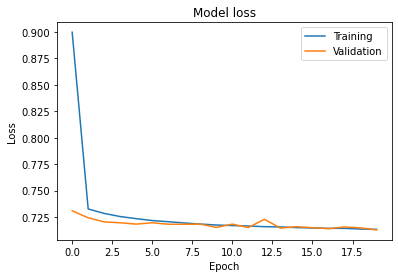

In [50]:
plt.plot(history.history['loss'], label = 'Training')
plt.plot(history.history['val_loss'], label = 'Validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()

RMSE of first deep learning model (0.8464) did not improve much compare to previous SVD collaborative-based filtering model (0.8628)

Further tuning on parameters can be done on the model to improve RMSE. See below for a model example with better RMSE:

In [51]:
%%time

# Setup variables
user_embedding_size = 10
movie_embedding_size = 20


##### Create model
# Set input layers
user_id_input = Input(shape=[1], name='user')
movie_id_input = Input(shape=[1], name='movie')

# Create embedding layers for users and movies
user_embedding = Embedding(output_dim=user_embedding_size, 
                           input_dim=users,
                           input_length=1, 
                           name='user_embedding')(user_id_input)
movie_embedding = Embedding(output_dim=movie_embedding_size, 
                            input_dim=movies,
                            input_length=1, 
                            name='movie_embedding')(movie_id_input)

# Reshape the embedding layers
user_vector = Reshape([user_embedding_size])(user_embedding)
movie_vector = Reshape([movie_embedding_size])(movie_embedding)

# Concatenate the reshaped embedding layers
concat = Concatenate()([user_vector, movie_vector])

# Combine with dense layers
dense = Dense(80, activation='relu')(concat)   #add activation function to dense layer and reduce layers from 256 to 80
dropout_1 = Dropout(0.5)(dense)   #add dropout regularistion to reduce overfitting
result = Dense(1)(dropout_1)

# Setup model
model = Model(inputs=[user_id_input, movie_id_input], outputs=result)
model.compile(loss='mse', optimizer='adam')


# Fit model

callbacks = [EarlyStopping('val_loss', patience=10),
             ModelCheckpoint('besttest.h5', save_best_only=True)]

history = model.fit([train_user_data, train_movie_data],
          df_train['Rating'],
          batch_size=256, 
          epochs=40,
          validation_split=0.1,
          callbacks=callbacks,
                   shuffle=True)

# Test model
y_pred = model.predict([test_user_data, test_movie_data])
y_true = df_test['Rating'].values

#  Compute RMSE
rmse = np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_true))
print('\n\nTesting Result With Keras Deep Learning: {:.4f} RMSE'.format(rmse))

Epoch 1/40
2980/2980 [==============================] - 3s 1ms/step - loss: 1.2634 - val_loss: 0.7401
Epoch 2/40
2980/2980 [==============================] - 3s 954us/step - loss: 0.8634 - val_loss: 0.7187
Epoch 3/40
2980/2980 [==============================] - 3s 965us/step - loss: 0.7583 - val_loss: 0.6953
Epoch 4/40
2980/2980 [==============================] - 3s 917us/step - loss: 0.7099 - val_loss: 0.6838
Epoch 5/40
2980/2980 [==============================] - 3s 1ms/step - loss: 0.6952 - val_loss: 0.6786
Epoch 6/40
2980/2980 [==============================] - 3s 942us/step - loss: 0.6862 - val_loss: 0.6721
Epoch 7/40
2980/2980 [==============================] - 3s 956us/step - loss: 0.6792 - val_loss: 0.6682
Epoch 8/40
2980/2980 [==============================] - 3s 965us/step - loss: 0.6733 - val_loss: 0.6657
Epoch 9/40
2980/2980 [==============================] - 3s 969us/step - loss: 0.6701 - val_loss: 0.6644
Epoch 10/40
2980/2980 [==============================] - 3s 1ms/step

RMSE of second DL model is 0.8022 , a better improvement compare to first DL model (0.8464)

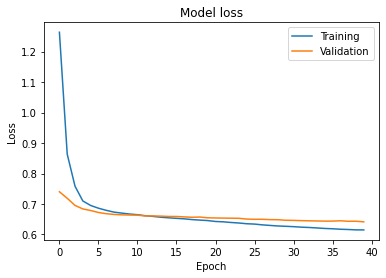

In [52]:
plt.plot(history.history['loss'], label = 'Training')
plt.plot(history.history['val_loss'], label = 'Validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()

In [53]:
min_val_loss, idx = min((val, idx) for (idx, val) in enumerate(history.history['val_loss']))
print('Minimum RMSE at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(np.sqrt(min_val_loss)))

Minimum RMSE at epoch 40 = 0.8009


In [54]:
print(model.summary())

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
movie (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 10)        43680       user[0][0]                       
__________________________________________________________________________________________________
movie_embedding (Embedding)     (None, 1, 20)        64700       movie[0][0]                      
_______________________________________________________________________________________